In [1]:
# データの読み込み
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# データの前処理設定
transfrom = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

# データセットの読み込み
data_dir = "/home/dataset/leaf_dataset/train"
dataset = datasets.ImageFolder(data_dir, transform=transfrom)

# 8:2でデータセットを分割
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# データローダー設定
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"訓練データセットのサイズ: {len(train_dataset)}")
print(f"検証データセットのサイズ: {len(val_dataset)}" )

訓練データセットのサイズ: 14545
検証データセットのサイズ: 3637


In [2]:
import torch.nn as nn
import torch.nn.functional as F

# CNNモデルの定義（先ほどCNNModelクラスをそのまま使用）
class CNNModel(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 100)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(100, num_classes)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# クラス数をデータセットに基づいて設定
num_classes = len(dataset.classes)  
model = CNNModel(num_classes=num_classes)

print("モデルの構造")
print(model)

モデルの構造
CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [3]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# GPUが使えるか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 損失関数と最適化関数の設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TensorBoardのWriterを定義
writer = SummaryWriter(log_dir="runs/CNNModel")

# トレーニング関数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    model.train()
    
    for epoch in range(num_epochs):
        # トレーニングフェーズ
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 勾配の初期化
            optimizer.zero_grad()
            
            # 順伝播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 逆伝播と最適化
            loss.backward()
            optimizer.step()
            
            # ロスの累計
            running_loss += loss.item()
            
            # 正解率の計算
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        # TrainデータにおけるLossとAccuracy
        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total

        # 検証フェーズ
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # 順伝播
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # 検証ロスの累計
                val_loss += loss.item()
                
                # 検証データでの正解率の計算
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # ValidationデータにおけるLossとAccuracy
        val_epoch_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # TensorBoardにログを追加 (TrainとValidationのLoss/Accuracy)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Accuracy/train", accuracy, epoch)
        writer.add_scalar("Loss/val", val_epoch_loss, epoch)
        writer.add_scalar("Accuracy/val", val_accuracy, epoch)
        
        # 結果の出力
        print(f"Epoch [{epoch+1}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    writer.close()

# モデルの訓練
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

Epoch [1], Loss: 1.1763, Accuracy: 61.75%, Val Loss: 1.1199, Val Accuracy: 61.95%
Epoch [2], Loss: 1.1337, Accuracy: 61.90%, Val Loss: 1.1229, Val Accuracy: 62.22%
Epoch [3], Loss: 1.1080, Accuracy: 62.03%, Val Loss: 1.0718, Val Accuracy: 62.58%
Epoch [4], Loss: 1.0940, Accuracy: 62.25%, Val Loss: 1.0682, Val Accuracy: 62.58%
Epoch [5], Loss: 1.0781, Accuracy: 62.57%, Val Loss: 1.0575, Val Accuracy: 62.80%
Epoch [6], Loss: 1.0651, Accuracy: 62.98%, Val Loss: 1.0542, Val Accuracy: 63.51%
Epoch [7], Loss: 1.0535, Accuracy: 62.99%, Val Loss: 1.0573, Val Accuracy: 63.54%
Epoch [8], Loss: 1.0371, Accuracy: 63.30%, Val Loss: 1.0493, Val Accuracy: 63.54%
Epoch [9], Loss: 1.0219, Accuracy: 63.91%, Val Loss: 1.0576, Val Accuracy: 63.43%
Epoch [10], Loss: 1.0178, Accuracy: 63.91%, Val Loss: 1.0483, Val Accuracy: 63.21%
Epoch [11], Loss: 0.9960, Accuracy: 64.46%, Val Loss: 1.0559, Val Accuracy: 63.05%
Epoch [12], Loss: 0.9855, Accuracy: 64.68%, Val Loss: 1.0498, Val Accuracy: 63.24%
Epoch [13], L

テストデータに対する正解率: 30.67%


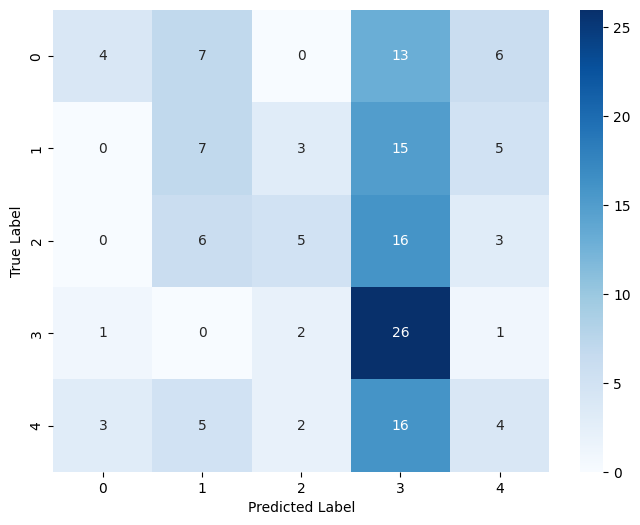

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 評価関数
def evaluate_model(model, test_loader, device):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 順伝播のみ
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 正解率の計算
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"テストデータに対する正解率: {accuracy * 100:.2f}%")
    
    # 混同行列の計算
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# データのディレクトリ設定(評価用)
test_dir = "/home/dataset/check"

# 評価データの前処理設定
test_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

# 評価データセットの読み込み
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# モデルの評価
evaluate_model(model, test_loader, device)